### Plot grit scores for Spheroid Aggregated data

In [1]:
import pandas as pd
import numpy as np
import os

# Grit scores
from cytominer_eval import evaluate

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("white")


# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D/spher_colo52_v1/3_GritScores
/share/data/analyses/christa/colopaint3D/spher_colo52_v1


In [2]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [3]:
cell_line = 'HCT116'
data_type = 'aggregates'

In [11]:
# Some function definitions

cell_line = 'HCT116'
# List all files in directory
dir = '1_Data/FeaturesImages_021224_none/WellAggregates/'

files = os.listdir(dir)

name = dir

# Select all files with HCT116 in the name as well as MedianAgg_meanstd
files = [file for file in files if cell_line in file and 'MedianAgg' in file]
# Load the parquet file into a pandas dataframe

# Load all files
data = []
for file in files:
    data.append(pd.read_parquet(dir + file))

data = pd.concat(data)



# # Load metadata (I am missing the concentrations)
# metadata = pd.read_csv('spher_colo52-metadata.csv')

In [21]:
# Some function definitions

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata

In [22]:
# Pycytominer
from pycytominer import feature_select

In [23]:
# Feature selection: "variance_threshold", "correlation_threshold", "drop_na_columns", "blocklist", "drop_outliers", "noise_removal",
to_clip_df = feature_select(data, features=list_features(data)[0], operation=["variance_threshold", "correlation_threshold","drop_na_columns", "blocklist"])

# Instead of removing the outliers, we can clip them
data2 = pd.concat([to_clip_df[list_features(to_clip_df)[1]], to_clip_df[list_features(to_clip_df)[0]].clip(lower=-40, upper=40, axis=1)], axis=1)
print(data2.shape)

(834, 365)


In [41]:
# # Load the data
# file = 'selected_data_all_grit.csv'
# data = pd.read_csv(file)

In [9]:
# data.Metadata_data_type.unique()

AttributeError: 'DataFrame' object has no attribute 'Metadata_data_type'

### Grit

In [24]:
# data2 = data.query("Metadata_cell_line == @cell_line").copy()
dataset_grit = data2.copy()
dataset_grit['Metadata_name'] = dataset_grit['Metadata_cmpdname'].str[:5] 

In [25]:
# ## Prepare the metadata for the grit calculation
# data = data.query("Metadata_cell_line == @cell_line & Metadata_data_type == @data_type").copy()
# dataset_grit = data.copy()

# Add a column with the step of the concentration (easier for plotting)
dataset_grit['Metadata_conc_step'] = (
    dataset_grit.groupby('Metadata_cmpdname')['Metadata_cmpd_conc'].rank(ascending=True, method='dense')
    )
# Add a column with the name of the perturbation (compound + concentration)
dataset_grit["Metadata_pert_name"] = (
    dataset_grit["Metadata_name"] + "_" + dataset_grit["Metadata_cmpd_conc"].astype(str)
    )
# Add a column with the a unique identifier for each replicate
dataset_grit["Metadata_replicate_id"] = (
    dataset_grit["Metadata_name"] + "_" + dataset_grit.index.astype(str)
    )

In [26]:
# Setup the data for calculating grit

# Set up the input for evaluate
control_perts = dataset_grit.query("Metadata_name == 'dmso' & Metadata_cmpd_conc == 0.1").Metadata_replicate_id.unique().tolist()
grit_replicate_groups = {"profile_col": "Metadata_replicate_id", "replicate_group_col": "Metadata_pert_name"} 

In [27]:
# Calcuate the grit scores

grit_scores = []

grit_results = evaluate(
    profiles=dataset_grit,
    features=list_features(dataset_grit)[0],
    meta_features=list_features(dataset_grit)[1],
    replicate_groups=grit_replicate_groups,
    operation="grit",
    similarity_metric="pearson",
    grit_replicate_summary_method="median",
    grit_control_perts=control_perts,
)

grit_scores.append(grit_results)

In [28]:
# Organize the grit scores

grit_scores = pd.concat(grit_scores).reset_index(drop=True)
grit_scores["Metadata_name"] = grit_scores["perturbation"].str.split("_").str[0]

# Add back the well information
grit_scores = pd.merge(grit_scores,dataset_grit[['Metadata_PlateWell', 'Metadata_replicate_id','Metadata_cmpd_conc', 'Metadata_conc_step', 'Metadata_pert_type']], left_on='perturbation', right_on='Metadata_replicate_id')

# list the compounds
CompoundsUsed = grit_scores["Metadata_name"].unique()

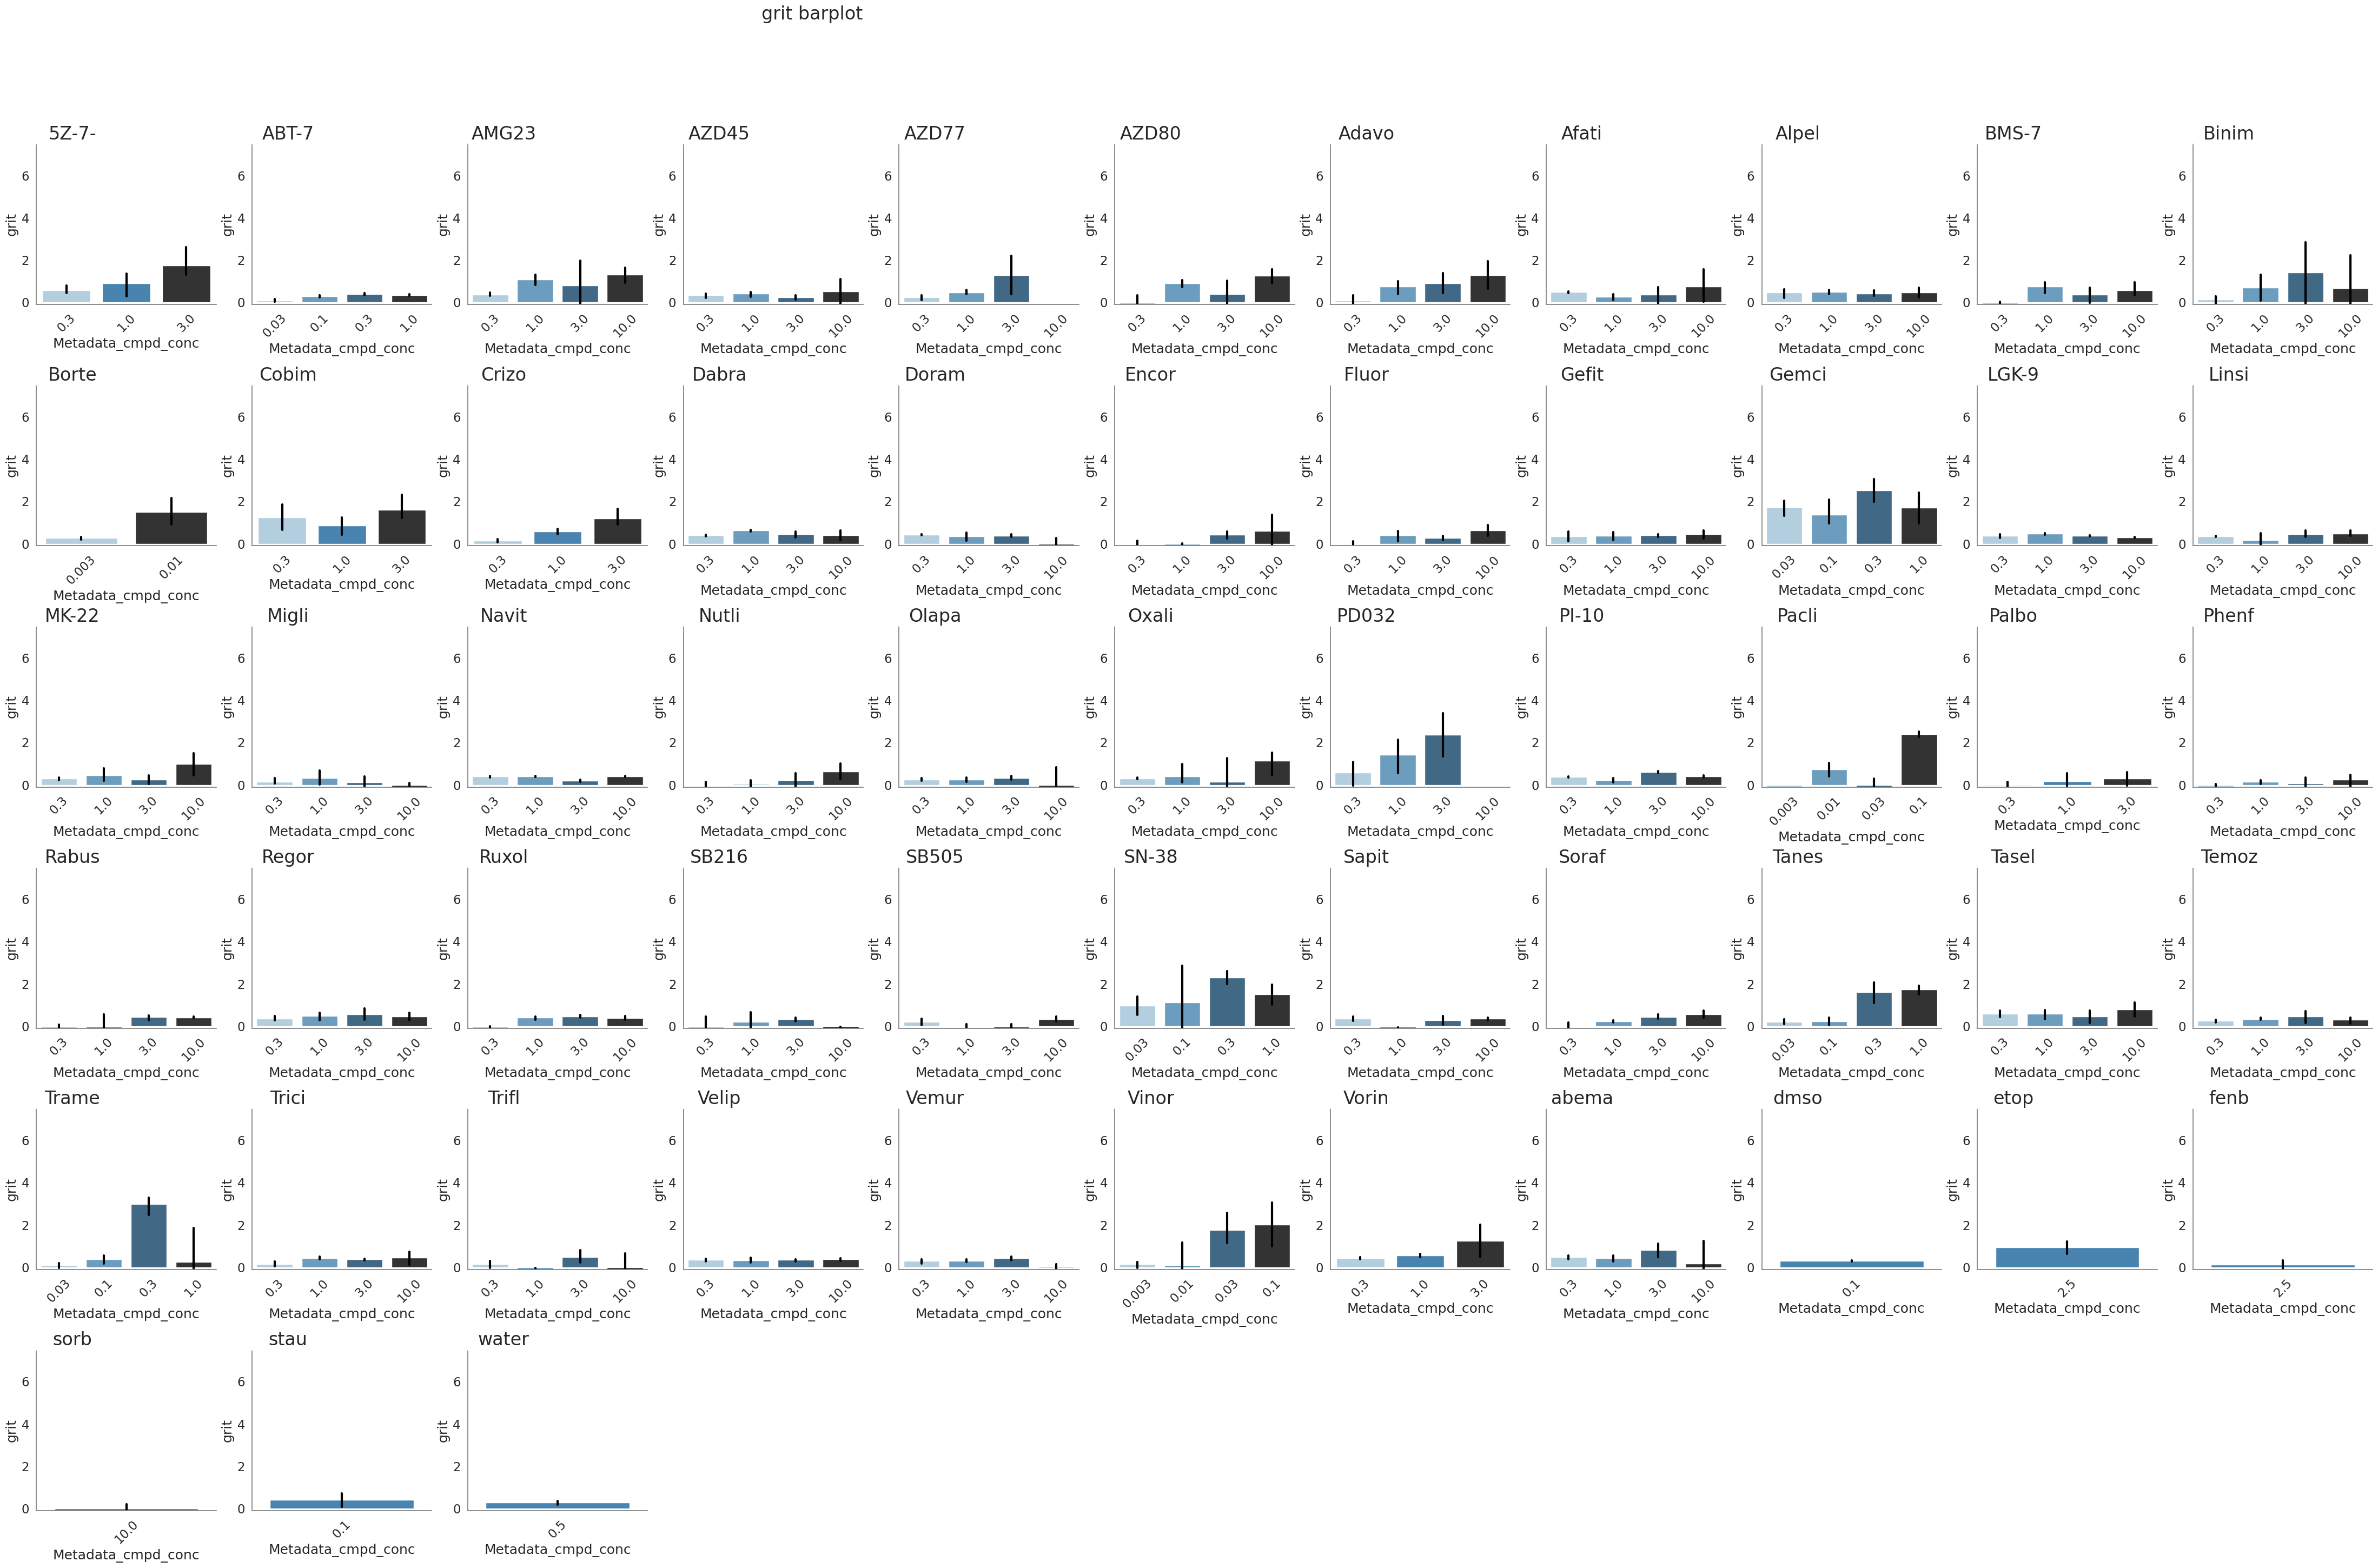

In [29]:
## Plot the grit dose response

# Plot the grit scores
fig = plt.figure(figsize=(48, 32))
sns.set(font_scale=1.5)
fig.suptitle("grit barplot ", fontsize=24, x=0.3)
sp = 1
nrrow = 6
nrcol = 11
for some in CompoundsUsed[:]:
    grit_scores_part = grit_scores[grit_scores["Metadata_name"] == some].copy()
    grit_scores_part.sort_values(by="Metadata_conc_step", inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax = sns.barplot(
        x="Metadata_cmpd_conc",
        y="grit",
        data=grit_scores_part,
        hue="Metadata_conc_step",
        legend=False,
        palette="Blues_d",
        alpha=1,
        err_kws={'linewidth': 3,'color': 'black'},
    )
    ax.set_facecolor("w")
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.set_ylim([-0.1, 7.5])
    ax.set_title("{}".format(some), fontsize=24, x=0.2)
    plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.5, left=0.0)
    plt.xticks(rotation = 45)
    sp += 1
    
# fig.savefig(
#         "{}/GritScores_{}.{}".format(OutputDir,cell_line,figformat), dpi=dpi, bbox_inches="tight"
#         )

plt.show()


#### Return a few statistics

In [49]:
## Stats

# Count the number of consensus grit scores above 1.96
average = grit_scores.query("Metadata_pert_type == 'trt'").groupby(['Metadata_name', 'Metadata_conc_step']).grit.median().sort_values(ascending=False)

# Find where the value is above 1.96 and return the Metadata_name
print(data_type + " " + cell_line)
print("Grit scores more than 1.96: " + str(average[average > 1.96].index.get_level_values(0).nunique()))
print(average[average > 1.96].index.get_level_values(0).unique())
print("Out of: " + str(average.index.get_level_values(0).nunique()))

print(grit_scores.query("Metadata_pert_type == 'trt'").grit.describe())

aggregates HCT116
Grit scores more than 1.96: 39
Index(['PD032', 'AMG23', 'AZD77', 'MK-22', 'Binim', 'BMS-7', 'Gemci', 'AZD45',
       'Encor', 'Trifl', 'Crizo', 'Cobim', '5Z-7-', 'SN-38', 'Trame', 'abema',
       'Tanes', 'Palbo', 'Oxali', 'Vinor', 'Regor', 'Afati', 'Olapa', 'Tasel',
       'Vorin', 'Borte', 'Nutli', 'Pacli', 'Adavo', 'Alpel', 'Dabra', 'Fluor',
       'PI-10', 'AZD80', 'Soraf', 'Gefit', 'Velip', 'Linsi', 'SB505'],
      dtype='object', name='Metadata_name')
Out of: 52
count    1494.000000
mean        2.074905
std         1.825098
min        -2.256682
25%         0.658973
50%         1.768477
75%         3.483927
max         7.817296
Name: grit, dtype: float64


In [50]:
# grit_scores_save = grit_scores.query("Metadata_pert_type == 'trt'").copy()

In [51]:
# grit_scores_2D = grit_scores.query("Metadata_pert_type == 'trt'").copy()

In [52]:
average1 = grit_scores_save.query("Metadata_pert_type == 'trt'").groupby(['Metadata_name', 'Metadata_conc_step']).grit.median().sort_values(ascending=False)
average2 = grit_scores_2D.query("Metadata_pert_type == 'trt'").groupby(['Metadata_name', 'Metadata_conc_step']).grit.median().sort_values(ascending=False)

s1 = average1[average1 > 1.96].index.get_level_values(0).unique()
s2 = average2[average2 > 1.96].index.get_level_values(0).str[:5].unique()

difference = s2[~np.isin(s2, s1)].tolist()
difference

NameError: name 'grit_scores_save' is not defined

In [ ]:
# For cmpds in difference, check what pathway they are in
dataset_grit.query("Metadata_name in @difference").groupby('Metadata_name').first()['Metadata_pathway']

Metadata_name
ABT-7                  Apoptosis
Doram                       MAPK
Linsi    Protein Tyrosine Kinase
Navit                  Apoptosis
Rabus                 Cell Cycle
Ruxol                   JAK/STAT
SB216              PI3K/Akt/mTOR
Sapit    Protein Tyrosine Kinase
Trici              PI3K/Akt/mTOR
Vemur                       MAPK
Name: Metadata_pathway, dtype: object

In [ ]:
# # # Count how many compounds have a grit score above 1.96
# # print("Grit scores more than 1.96: " + str(average.query("grit > 1.96 & Metadata_pert_type == 'trt'").Metadata_name.nunique()))
# # print("Out of: " + str(average.query("Metadata_pert_type == 'trt'").Metadata_name.nunique()) + " compounds")

# grit_scores.query("Metadata_pert_type == 'trt'").grit.describe()

# print("Grit scores more than 1.96: " + str(grit_scores.query("grit > 1.96 & Metadata_pert_type == 'pos_con'").Metadata_name.unique()))

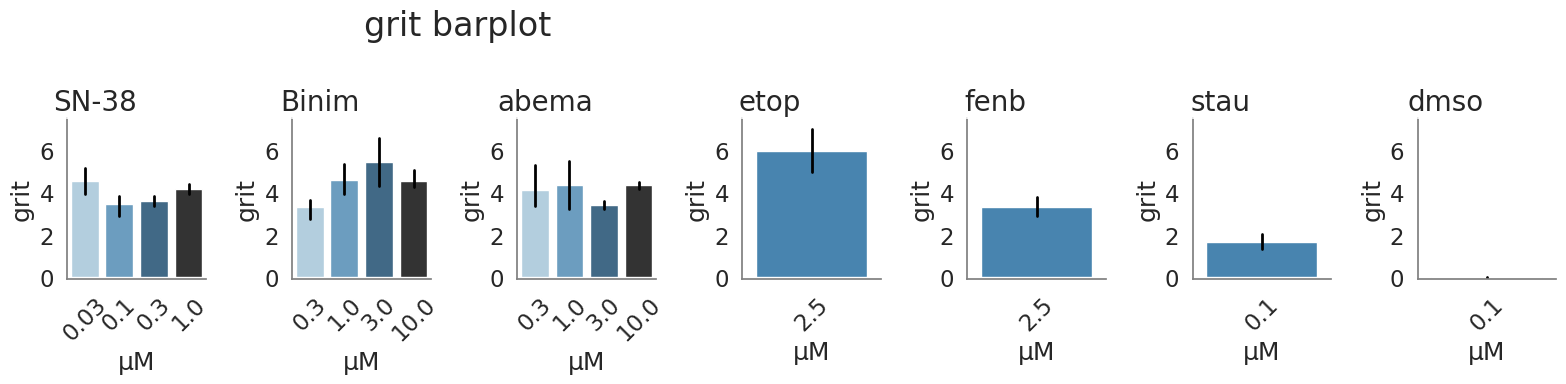

In [ ]:
# Plot only a handful of compounds for the main figure

CompoundsUsed = ['SN-38', 'Binim', 'abema', 'etop','fenb','stau','dmso']


# Plot the grit scores
fig = plt.figure(figsize=(16, 4))
# sns.set(font_scale=1.5)
fig.suptitle("grit barplot ", fontsize=24, x=0.3)
sp = 1
nrrow = 1
nrcol = 7
for some in CompoundsUsed[:]:
    grit_scores_part = grit_scores[grit_scores["Metadata_name"] == some].copy()
    grit_scores_part.sort_values(by="Metadata_conc_step", inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax = sns.barplot(
        x="Metadata_cmpd_conc",
        y="grit",
        data=grit_scores_part,
        hue="Metadata_conc_step",
        legend=False,
        palette="Blues_d",
        alpha=1,
        err_kws={'linewidth': 2,'color': 'black'},
    )
    ax.set_facecolor("w")
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.set_yticks([0, 2, 4, 6])
    ax.set_ylim([-0.1, 7.5])
    ax.set_xlabel('µM')
    ax.set_title("{}".format(some), fontsize=20, x=0.2)
    plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.5, left=0.0)
    plt.xticks(rotation = 45)
    sp += 1

    fig.tight_layout()
    
# fig.savefig(
#         "3_GritScores/result-images/GritScores_{}_{}.{}".format(cell_line, data_type, figformat), dpi=dpi, bbox_inches="tight"
#         )

plt.show()

### Run all conditions and then save them in a file

In [ ]:
# dataset_full = pd.DataFrame()

In [ ]:
# # Check what it has now 
# print(dataset_grit.Metadata_data_type.unique(), dataset_grit.Metadata_cell_line.unique())

In [ ]:
# # Attach the grit scores to the original data
# tmp2 = pd.merge(dataset_grit, grit_scores[['Metadata_PlateWell', 'Metadata_cmpd_conc', 'grit']], on=['Metadata_PlateWell', 'Metadata_cmpd_conc'], how='left')
# dataset_full = pd.concat([dataset_full, tmp2], axis=0)

In [ ]:
# # Check what it has now 
# print(dataset_full.Metadata_data_type.unique(), dataset_full.Metadata_cell_line.unique())

In [ ]:
# # Rename grit to Metadata_grit
# dataset_full.rename(columns={'grit': 'Metadata_grit'}, inplace=True)

In [ ]:
# # Save the data
# dataset_full.to_csv('selected_data_all_grit.csv', sep=',', index=False)